##                      WORKSHOP 2: ORGANIC DATA GENERATION II
In this second workshop, we will continue to derive new variables, this time focusing on natural language processing (NLP) tools.  



### TASK 1: Exploring Tokenization and POS-Tagging 
Some of us may have used the word_tokenize module from the nltk package in Workshop 1. For those who didn't, let's try it again to see how it takes in text and separates it into a list of words like this:

 
`words = nltk.word_tokenize(text)`



Next, let's also explore the part-of-speech tagger (POS tagger). A part of speech tagger takes in a list of words and assigns it tag so that we can distinguish noun, verb, adjective, etc. The output is a list of tuples, where the first item in the tuple is the word and the second item is the tag.  


`tagged_words = nltk.pos_tag(list_of_words)`


For a full list of tags, see: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

<hr >

**_Hint_: Looping through a list of tuples**
Looping through a list of tuples is quite similar to looping through a simple list. 
Say you have a list xy_list =[(x1, y1), (x2, y2), (x3, y3)....] and you want to extract only the x's:



`x_list=[]` <br>
`for (x,y) in xy_list:`<br>
     
     x_list.append(x)

### TASK 2: POS-tagging personal summaries
We will read in the (new) employees DataFrame that we saved as a pickle file in Workshop 1. Then, we will pos_tag each summary to create a new list `tagged_summary`.


In [23]:
import pandas as pd
import nltk

# Reading in Pickle File
employees_df = pd.read_pickle('./Data/employees_df.pkl')

# Generating tagged_summary list 
tagged_summary =[]
for s in employees_df.personal_summary:
    words = nltk.word_tokenize(s)
    tagged_words = nltk.pos_tag(words)
    tagged_summary.append(tagged_words)




### TASK 3: Revisiting summary sentiments
In workshop 1, we assigned a sentiment score to each summary using the full summary text. What if we just use adjectives? Is this more appropriate than using every word in the summary?

In this task, we will repeat the SentimentIntensityAnalyzer from Workshop 1, but only for the adjectives in the summary. Lets create a new column in employees_df, `adjective_positivity`, which measures the positiveness of the adjectives used. Note that the pos-tags for adjectives are JJ, JJR, JJS.  

Once done, check the correlation between summary_positivity and adjective_positivity. What does this insinuate? 



In [24]:
import numpy as np
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


adjective_positivity=[]
adjective_list =['JJ', 'JJR', 'JJS']

for s in tagged_summary:
    word_list = [wrd for (wrd,tg) in s if tg in adjective_list]
    refined_list = [word for word in word_list if word not in stopwords.words('english')]
    pos_words=0
    neg_words=0
    neu_words=0
    for word in refined_list:
        sent = sid.polarity_scores(word)
        if  sent['pos'] > sent['neg']:
            pos_words+=1
        elif sent['pos'] < sent['neg']:
            neg_words+=1
        else:
            neu_words+=1
    numerator = pos_words
    denominator = pos_words+neg_words+neu_words
    denominator = max(denominator,1)  # to avoid dividing by 0
    sent_score = numerator/float(denominator)       
    adjective_positivity.append(sent_score)

employees_df['adjective_positivity'] = adjective_positivity     

# Checking the correlation coefficient
np.corrcoef(adjective_positivity, employees_df.summary_positivity)

array([[ 1.        ,  0.45294297],
       [ 0.45294297,  1.        ]])

#### TASK 3B _Optional_: Visualizing the difference in sentiments by department
The aim of this task is to create grouped box-plots to examine if and how redefining how we measure sentiment changes the conclusions we drew about department-level satisfaction. 

Similar to what we did with grouped bar charts, we can generate grouped box-plots by playing with the positions of boxes. You can read more here: https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots


To complete this task, we will need three nested lists, one for each department. Lets name these `finance_scores`, `InE_scores`, and `management_scores`. Each list will contain two lists, the first is the list of sentiment scores for the department using the full text and the second using only adjectives. Specifically, `finance_scores = [[summary_positivity for dept], [adjective_positivity for dept]].`

Once all three lists are generated, we can plot the grouped boxplots like this:

`
bp = plt.boxplot(finance_scores, positions = [2, 3], widths = 0.5)
bp =  plt.boxplot(InE_scores, positions = [5, 6], widths = 0.5)
bp =  plt.boxplot(management_scores, positions = [8, 9], widths = 0.5)
`




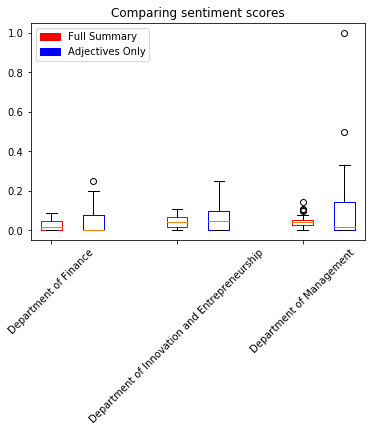

In [25]:
import matplotlib.pyplot as plt
# This makes plots appear in the notebook
%matplotlib inline


def locate_in_list(list_of_items,element):
    item_idx= [i for i, x in enumerate(list_of_items) if x == element]
    return(item_idx)

# First, generating the values on the x-axis and saving them in X AND generating the values in each boxplot (bp), and saving them in bp
unique_depts = list(np.unique(employees_df.department))

# Initializing empty lists
finance_scores = []
InE_scores=[] 
management_scores=[]


# Looping through departments to populate the three nested lists 
for dept in unique_depts:
    dept_idx = locate_in_list(list(employees_df.department), dept)
    senti_scores = [employees_df.summary_positivity[x] for x in dept_idx]
    adj_scores = [employees_df.adjective_positivity[x] for x in dept_idx]
    if dept =='Department of Finance':
        finance_scores =[senti_scores,adj_scores]
    elif dept == 'Department of Innovation and Entrepreneurship':
        InE_scores =[senti_scores, adj_scores]
    else: 
        management_scores =[senti_scores, adj_scores]

# Changing boxplot color
def colorize_boxplot_pair(bp_pair):
    boxplot_boxes = bp_pair['boxes']
    boxplot_boxes[0].set(color='red')
    boxplot_boxes[1].set(color='blue')
    
# Adding Legend
import matplotlib.patches as mpatches
def add_legend():
    patch1 = mpatches.Patch(color='red')
    patch2 = mpatches.Patch(color='blue')
    label1 = 'Full Summary'
    label2 = 'Adjectives Only'
    
    plt.legend([patch1,patch2],[label1, label2])
            
# Plotting boxplot for length of summary
bp = plt.boxplot(finance_scores, positions = [2, 3], widths = 0.5)
colorize_boxplot_pair(bp)
bp =  plt.boxplot(InE_scores, positions = [5, 6], widths = 0.5)
colorize_boxplot_pair(bp)
bp =  plt.boxplot(management_scores, positions = [8, 9], widths = 0.5)
colorize_boxplot_pair(bp)
add_legend()

# Setting lower limit of x
plt.xlim(left=1.5)

# Setting xticks
plt.xticks([2, 5, 8], unique_depts, rotation = 45)



#  Setting a title, and axes labels
plt.title('Comparing sentiment scores')
plt.show()
    

### TASK 4: Generating a similarity score. 
#### STEP 1: Start by creating a definition to extract nouns

We'll measure the similarity between employees as a function of the commonality/overlap in the nouns in their personal summaries. Why do you think using nouns is important here? 

Let's change things up a bit, and create a definition/function that extracts only nouns. Creating functions is quite useful as they can be reused.

The steps are as follows: 
>- First, tokenize the text using nltk.word_tokenize(text).
>- Second, use part-of-speech tagger to tag the words outputted in 
>- Third, loop through tags and keep only nouns (create a list of nouns). Nouns have the following tags keep nouns only (nn, nns, nnp, nnps)  

<hr>
**_Hint _**: The example below shows a function that returns the sum of two input variables (a, b). A function has a name (e.g., sum_two_numbers) and input variables (e.g., a, b). Then it performs an operation, and returns a value (e.g., sum_equals). 

`

def sum_two_numbers(a, b):<br>
   > sum_equals = a+b <br>
    return sum_equals <br>


`


In [26]:
def extract_nouns(text):
    # use tokenizer to split text into individual words
    words = nltk.word_tokenize(text)    
    # use tagger to categorize all words
    tags = nltk.pos_tag(words)
    # keep nouns only (nn, nns, nnp, nnps)
    only_nouns = []
    for word, pos in tags: 
        if (pos == 'NN' or pos == 'NNS' or pos == 'NNP' or pos == 'NNPS'):
            only_nouns.append(word.lower())
    return only_nouns  

#### TASK 4, Step 2: Create a function that removes stop words.
Previously, we used common English stopwords from the nltk toolkit. That was a quick and easy way of removing common words (stop words). However, we can make it context specific by removing words that commonly appear in the text we are analyzing. Can you think of some advantages of doing this?

We will define stop words as words with frequencies in the top quantile. The steps are as follows:

>- First, use counts= Counter(word_list) to count the number of words that appears in list. Counter returns a dict. where the counts.keys() are the unique items in word_list and counts.values() are the number of times each key occurs.
>-  Second, loop through each key in counts and (i) append key to new_word_list and (ii) calculate freq. as the number of times key (i.e., word) occurs: counts[key] divided by the total number words in the list (i.e., sum(counts.values())
>-  Third, if frequency> threshold ( in this case, np.percentile(freq,75)), add the word to the stop list.





In [27]:
from collections import Counter

def stop_words(word_list):
    counts = Counter(word_list)
    stop_list =[];
    new_word_list=[]
    freq=list(counts.values())
    for i in range(len(freq)):
        if freq[i] > np.percentile(freq,.75):
            stop_list.append(list(counts.keys())[i])
        else:
            new_word_list.append(list(counts.keys())[i])
    return (new_word_list, stop_list)

#### TASK 4, Step 3: Define similarity.
Create a definition for the  similarity of two lists as the number of items in the intersection of lst1 & lst2 divided by the number of items in the union of lst1 and lst2.

To simplify thist task, I have defined intersect and union for you.

**_Note_**: In your definition, you will need to include an if statement which returns a value of 0 for similarity if the union of the two lists is empty


In [28]:
def intersect(a, b):
    return list(set(a) & set(b))
def union (a,b):
    return  list(set(a).union(b))
       
def similarity(lst1, lst2):
    numerator =  len(intersect(lst1,lst2))
    denom = len(union(lst1,lst2))
    if not denom:
        sim = 0
    else:
        sim = round(float(numerator)/denom,3)
    return sim   


### TASK 5: Creating a similarity vector for each employee 
In this task, we will create a similarity vector for each employee which should reflect that person's similarity to all other employees. A vector for person one will look something like this similarity_vector= [s11,s12, s13, ....., s1n], where sij is the similarity of person i to person j. Once the vector is generated, we will add it to a dictionary, `similarity_dict`, where keys are person_id's (i.e., `employees_df.person_id[i]`] and and values are these similar vectors.

The following steps will help:
- First, we want to remove all stop words from employee summaries. To do this, we will need to create a text comprising of all summaries. This step is important because we want to calculate the frequency of words across all the text.  
>- Use the `join` command to join all summaries together, and tokenize.
>- Call the `stop_word` function.

- Using a nested for loop, populate a similarity vector for each employee, then add each vector to `similarity_dict`  

<hr>

**_Hint _**: You'll be looping through person_id twice so that you can compare person_id[i] to person_id[j]:


`
for i in range(len(employees_df.personal_summary)):   
    
    sim_vect = []
    
    for j in range(len(employees_df.personal_summary)):
        # CODE TO FIND SIMILARITY SCORE BETWEEN i an j's GOES HERE, VALUE APPENDED TO sim_vect   
    
    CODE TO ADD sim_vect TO similarity_dict {}   
`


In [29]:
import string

# join can help us concatenate items in a list into a single item. I use it here to create a single text out of all personal summaries.
all_summaries= ' '.join(list(employees_df.personal_summary))


#Tokenize
all_summaries_words= nltk.word_tokenize(all_summaries)

# Remove all punctuation
things_to_exclude = set(string.punctuation)
#all_summaries_clean = ''.join(p for p in all_summaries if p not in things_to_exclude)
all_summaries_clean=[]
for item in all_summaries_words:
    if item not in things_to_exclude:
        all_summaries_clean.append(item)
    

# Removing stop words from all summaries
(new_wordlist, stop_words) = stop_words(all_summaries_clean)



# Creating a "universal" list of nouns (without stop words)
noun_list = ['NN', 'NNS', 'NNP', 'NNPS']
tagged_wordlist = nltk.pos_tag(all_summaries_clean)
new_wordlist_nouns=[]
for x,y in tagged_wordlist:
    if y in noun_list and y not in stop_words:
        new_wordlist_nouns.append(x)

        
# Next, compare pairs of employees and create a summary score.
similarity_dict ={}

# Loop through to create a similarity score between pairs of employees.
for i in range(len(employees_df.personal_summary)):
    sim_vect = []
    s1 =  intersect(nltk.word_tokenize(employees_df.personal_summary[i]), new_wordlist_nouns)
    for j in range(len(employees_df.personal_summary)):
        s2 =  intersect(nltk.word_tokenize(employees_df.personal_summary[j]), new_wordlist_nouns) 
        sim_vect.append(similarity(s1,s2))
    similarity_dict[employees_df.person_id[i]]= sim_vect    
      

### TASK 6: Measuring within-department and out-of-department similarity between colleagues 
In this task, we will loop through the employees in our sample and create an average in-department similarity score, which measures the average similarity score between that individual and others in the same department and a second out-of-department similarity score, which measures the average similarity score to colleagues from different departments. 

We'll create two lists, `dept_similarity` which contains the average similarity scores of each individual with others in the department. We'll also create `outdept_similarity` which is a list containing average similarity scores of each individual with colleagues in other departments. How do they differ and why?


In [30]:
dept_similarity=[]
outdept_similarity=[]
for i in range(len(employees_df.person_id)):
    pid = employees_df.person_id[i]
    dept = employees_df.department[i]
    dept_idx = locate_in_list(list(employees_df.department), dept) 
    sim_scores = similarity_dict[pid]
    dept_similarity.append(np.mean([sim_scores[x] for x in range(len(sim_scores)) if x in dept_idx]))
    outdept_similarity.append(np.mean([sim_scores[x] for x in range(len(sim_scores)) if x not in dept_idx]))    

employees_df['dept_similarity']= dept_similarity
employees_df['outdept_similarity'] = outdept_similarity

### TASK 7 _optional_: Visualize the difference between in- and out-of department similarity
A box plot is a good tool for examining the differences between the two similarity scores we created. Another alternative is a jitter plot, which can be generated the way we would a scatter plot, but with some "noise" added to the data.    



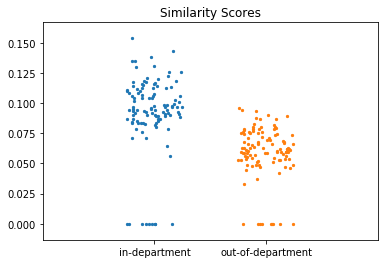

In [31]:
def generate_jitter_plot(dept_similarity, outdept_similarity):
    dept_x_pos = 2
    outdept_x_pos = 4
    spread = 0.5
    
    dept_x_values = np.repeat(dept_x_pos, len(dept_similarity)) + np.random.uniform(-spread, spread, len(dept_similarity))
    outdept_x_values = np.repeat(outdept_x_pos, len(dept_similarity)) + np.random.uniform(-spread, spread, len(dept_similarity))
    
    marker_size = 5    
    dept = plt.scatter(dept_x_values, dept_similarity, s=marker_size)#, color='red')
    out_dept = plt.scatter(outdept_x_values, outdept_similarity, s=marker_size)#, color='blue')
    
    plt.xlim(0,6)
    plt.xticks([2,4], ['in-department', 'out-of-department'])
    plt.title('Similarity Scores')
    
generate_jitter_plot(dept_similarity, outdept_similarity)

### TASK 8: Saving our new data
Our employees_df has even more rows now. Let's save it using `employees_df.to_pickle` as we did last time. Let's also save `similarity_dict`, as we will use this to generate our networks and clusters.

In [32]:
# Saving employees_df
employees_df.to_pickle('./Data/employees_df.pkl')

# Converting similarity_dict to pickle
sim_data = []
for key in similarity_dict:
    sim_data.append({'person_id': key, 'similarity_vector': similarity_dict[key]})
similarity_df = pd.DataFrame(data=sim_data)    

# Saving similarity_df
similarity_df.to_pickle('./Data/similarity_df.pkl')
